In [1]:
import pandas as pd
from dataset_manager import DatasetManager
import seaborn as sns
from matplotlib import pyplot as plt


dataset_path = "./datasets"
manager = DatasetManager(dataset_path)

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 0)

# Criação de pipeline

In [3]:
class Pipeline:
    def __init__(self):
        self.pipeline = []
    
    def add_pipeline(self, func):
        self.pipeline.append(func)
    
    def run(self, df, ano):
        for i in self.pipeline:
            i(df, ano)
            print("="*20)

In [4]:
pipeline =  Pipeline()

# Analise de valor Pago

In [5]:
def cast_serie_to_float(serie):
    return serie.apply(lambda x: float(x.replace(",",".")))
    

In [6]:

def plot_hist(serie, title, **kwargs):
    plt.figure(figsize=(16, 6))
    valor_pago_plot = sns.distplot(serie.dropna(), **kwargs)
    valor_pago_plot.set_title(title)
    valor_pago_plot;

def second_step(df, ano):
    df.loc[:,"Valor pago_fmt"] = cast_serie_to_float(df["Valor pago"])
    plot_hist(df["Valor pago_fmt"], "Histograma do valor pago por Contrato [{}]".format(ano), kde=False, bins=50)

pipeline.add_pipeline(second_step)

# Valor total investido em merenda

In [7]:
def second_b_step(df, ano):
    r = df["Valor pago_fmt"].sum()
    print("Valor total gasto com contratos [{}]: R${:20,.2f}".format(ano, r))
    
    r2 = len(df["Favorecido"].unique())
    print("Quantidade de Favorecidos [{}]: {}".format(ano, r2))

pipeline.add_pipeline(second_b_step)

# Analise de Tempo de Contrato

In [8]:
def convert_to_datetime(serie):
    return pd.to_datetime(serie)


In [9]:
def days_between_dates(serie_inicio, serie_fim):
    return (serie_fim - serie_inicio).dt.days


def third_step(df, ano):
    df.loc[:,'Data início previsto_fmt']=convert_to_datetime(df['Data início previsto'])
    df.loc[:,'Data fim previsto_fmt']=convert_to_datetime(df['Data fim previsto'])

    df.loc[:,'Data da assinatura_fmt']=convert_to_datetime(df['Data da assinatura'])
    df.loc[:,'Data do encerramento_fmt']=convert_to_datetime(df['Data do encerramento'])
    
    df.loc[:,'Dias previstos'] = days_between_dates(
    df['Data início previsto_fmt'],
    df['Data fim previsto_fmt'])

    df.loc[:,'Dias assinatura_encerramento'] = days_between_dates(
    df['Data da assinatura_fmt'],
    df['Data do encerramento_fmt'])
    
    plot_hist(df['Dias previstos'], "Dias previstos do contrato [{}]".format(ano), kde=False)
    plot_hist(df['Dias assinatura_encerramento'], 'Dias do contrato [{}]'.format(ano), kde=False)
    
pipeline.add_pipeline(third_step)

# Analise de diferença de valores

In [10]:
def forth_step(df,ano):
    df.loc[:, "Valor inicial do instrumento_fmt"] = cast_serie_to_float(df["Valor inicial do instrumento"])
    df.loc[:,"diferenca de valores"] = df["Valor inicial do instrumento_fmt"] - df["Valor pago_fmt"]
    r = df[df["diferenca de valores"] != 0.0 ][["Favorecido",
                                            "Dias assinatura_encerramento",
                                            "Valor inicial do instrumento",
                                            "Valor pago",
                                            "diferenca de valores",
                                            "Descrição do órgão executor"]]
    print("Diferença entre valores acordados e pagos [{}]".format(ano))
    print(r)
    
    
pipeline.add_pipeline(forth_step)

# Analise de pagamos em contratos por Favorecido

In [11]:
def fifth_step(df,ano):
    df_grouped = df.groupby(["Favorecido", "Código favorecido", "Descrição do órgão executor"], as_index=False).sum()
    plot_hist(df_grouped["Valor pago_fmt"], "Valor pago por Favorecido [{}]".format(ano), kde=False, bins=90)

pipeline.add_pipeline(forth_step)

# Analise de quantos Favorecidos tem o nome `Escola` ou `Creche`


In [12]:
def sixth_step(df,ano):
    r = df[(df["Favorecido"].str.contains("ESCOLA")) | 
       (df["Favorecido"].str.contains("CRECHE"))].shape[0]
    print("Quantidade de favorecidos com nome ESCOLA ou CRECHE [{}]: {}".format(ano, r))
pipeline.add_pipeline(sixth_step)

# R1 - Execução para 2016

/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Valor total gasto com contratos [2016]: R$        2,738,140.00
Quantidade de Favorecidos [2016]: 96
Diferença entre valores acordados e pagos [2016]
                                     Favorecido  Dias assinatura_encerramento  ... diferenca de valores       Descrição do órgão executor
535  ASSOCIACAO DE MORADORES DO MORRO DA BAIANA  385                           ...  6400.0               SECRETARIA MUNICIPAL DE EDUCAÇÃO

[1 rows x 6 columns]
Diferença entre valores acordados e pagos [2016]
                                     Favorecido  Dias assinatura_encerramento  ... diferenca de valores       Descrição do órgão executor
535  ASSOCIACAO DE MORADORES DO MORRO DA BAIANA  385                           ...  6400.0               SECRETARIA MUNICIPAL DE EDUCAÇÃO

[1 rows x 6 columns]
Quantidade de favorecidos com nome ESCOLA ou CRECHE [2016]: 28


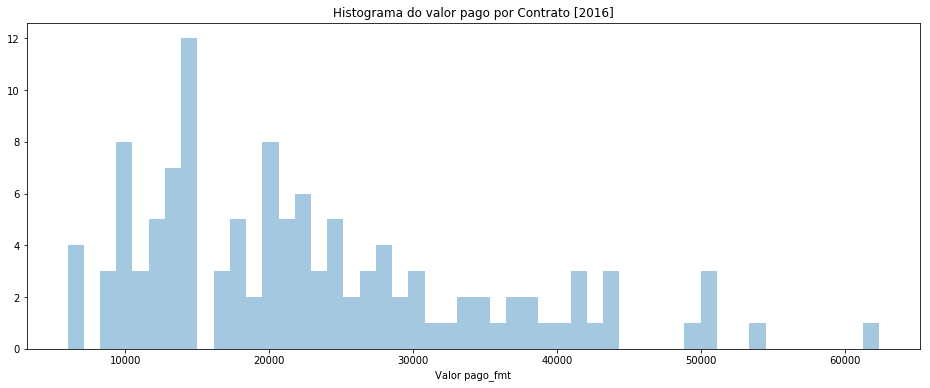

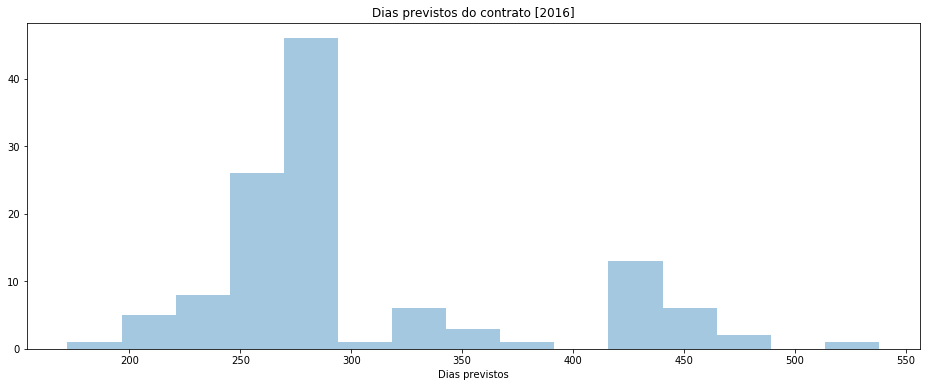

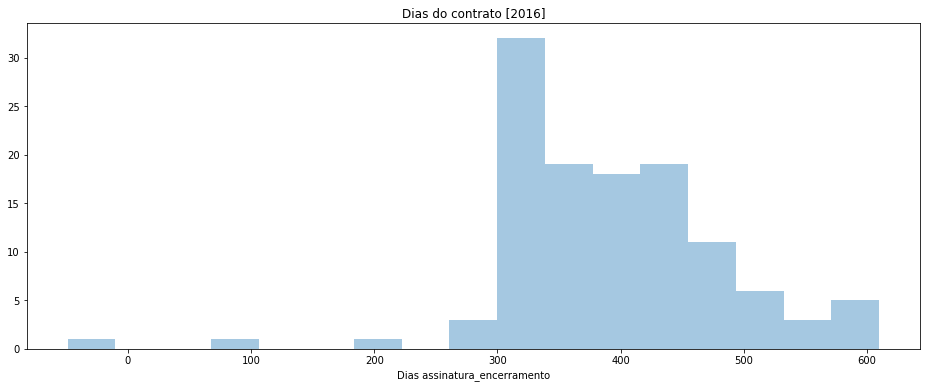

In [13]:
dataset = manager.get_dataset("riotransparente_contratos_2016")
df = dataset.load_as_pandas(error_bad_lines=False, encoding='latin-1', sep=";")
def filtro_merenda(df):
    return df[df["Descrição da fonte de recursos"] == "TRANSFERENCIA DO GOVERNO FEDERAL PARA MERENDA ESCOLAR"]

df_merenda = filtro_merenda(df)

pipeline.run(df_merenda, "2016")

Valor total gasto com contratos [2017]: R$        3,786,855.02
Quantidade de Favorecidos [2017]: 105
Diferença entre valores acordados e pagos [2017]
                                                        Favorecido  ...             Descrição do órgão executor
987   ASSOCIACAO FILHAS DE SANTA MARIA DA PROVIDENCIA               ...  SECRETARIA MUNICIPAL DE EDUCAÇÃO      
1301  UNIAO DAS ASSOCIACOES E COOPERATIVAS USUARIAS DO PAVILHAO 30  ...  5A. COORDENADORIA REGIONAL DE EDUCAÇÃO
1495  UNIAO DAS ASSOCIACOES E COOPERATIVAS USUARIAS DO PAVILHAO 30  ...  5A. COORDENADORIA REGIONAL DE EDUCAÇÃO

[3 rows x 6 columns]
Diferença entre valores acordados e pagos [2017]
                                                        Favorecido  ...             Descrição do órgão executor
987   ASSOCIACAO FILHAS DE SANTA MARIA DA PROVIDENCIA               ...  SECRETARIA MUNICIPAL DE EDUCAÇÃO      
1301  UNIAO DAS ASSOCIACOES E COOPERATIVAS USUARIAS DO PAVILHAO 30  ...  5A. COORDENADORIA REGIONAL DE EDUC

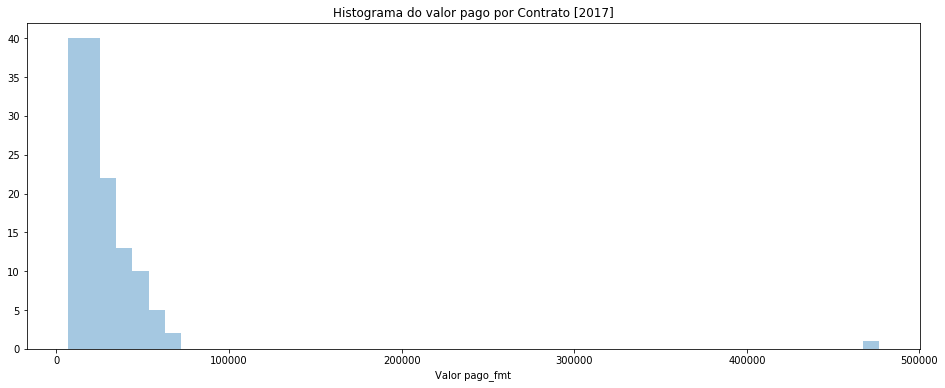

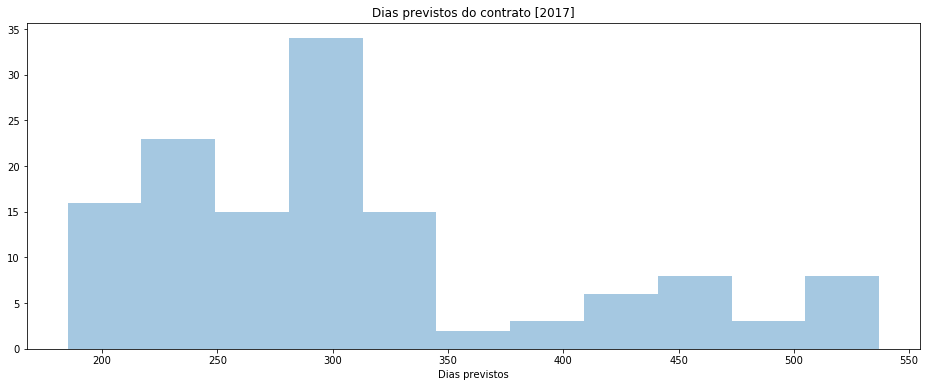

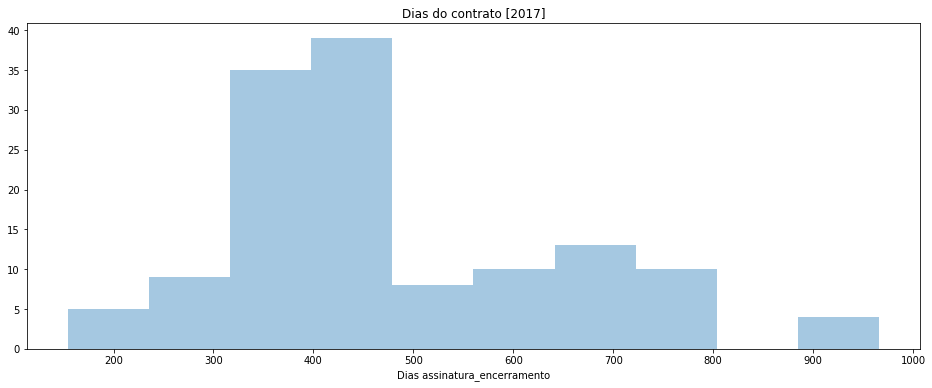

In [14]:
dataset = manager.get_dataset("riotransparente_contratos_2017")
df = dataset.load_as_pandas(error_bad_lines=False, encoding='latin-1', sep=";")

df_merenda = filtro_merenda(df)

pipeline.run(df_merenda, "2017")

Valor total gasto com contratos [2018]: R$        5,459,270.96
Quantidade de Favorecidos [2018]: 118


/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Diferença entre valores acordados e pagos [2018]
                                                        Favorecido  ...             Descrição do órgão executor
2564  COMERCIAL MILANO BRASIL LTDA.                                 ...  1A. COORDENADORIA REGIONAL DE EDUCAÇÃO
3320  UNIAO DAS ASSOCIACOES E COOPERATIVAS USUARIAS DO PAVILHAO 30  ...  5A. COORDENADORIA REGIONAL DE EDUCAÇÃO

[2 rows x 6 columns]
Diferença entre valores acordados e pagos [2018]
                                                        Favorecido  ...             Descrição do órgão executor
2564  COMERCIAL MILANO BRASIL LTDA.                                 ...  1A. COORDENADORIA REGIONAL DE EDUCAÇÃO
3320  UNIAO DAS ASSOCIACOES E COOPERATIVAS USUARIAS DO PAVILHAO 30  ...  5A. COORDENADORIA REGIONAL DE EDUCAÇÃO

[2 rows x 6 columns]
Quantidade de favorecidos com nome ESCOLA ou CRECHE [2018]: 32


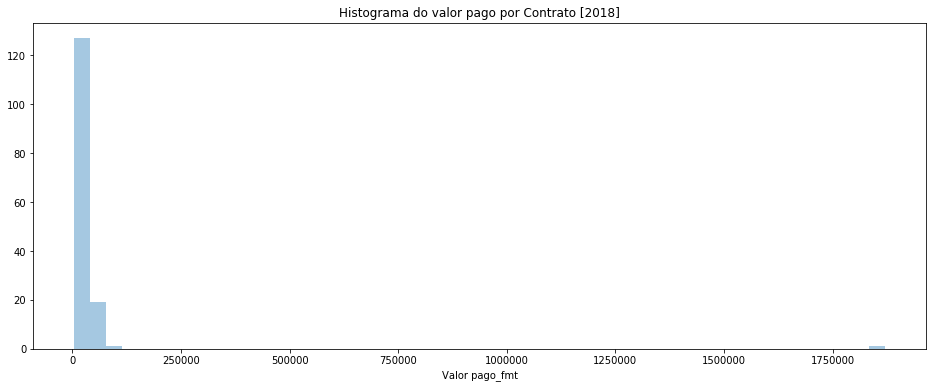

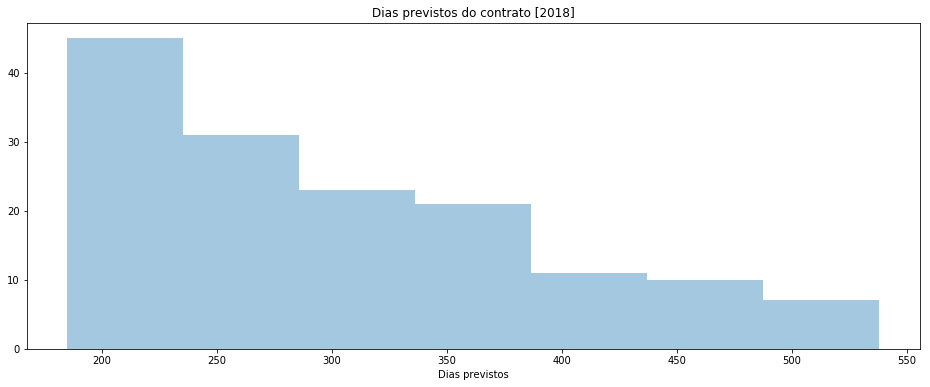

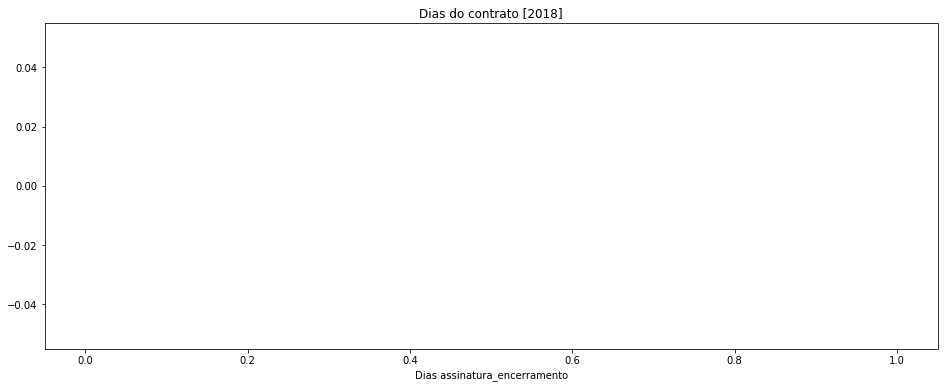

In [15]:
dataset = manager.get_dataset("riotransparente_contratos_2018")
df = dataset.load_as_pandas(error_bad_lines=False, encoding='latin-1', sep=";")

df_merenda = filtro_merenda(df)

pipeline.run(df_merenda, "2018")